<a href="https://colab.research.google.com/github/tcmle/ml_notes/blob/master/News_Classification_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2022-01-22 08:48:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.04s   

2022-01-22 08:48:22 (121 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [ ]:
vocab_size = 10000
embedding_dim = 32
max_length =120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<oov>'
training_portion = .8

In [ ]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))
print("is" in stopwords)
# Expected Output
# 153

153
True


In [ ]:
df=pd.read_csv("/tmp/bbc-text.csv")
print(df.head())

print(set(df.category))

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...
{'politics', 'entertainment', 'business', 'sport', 'tech'}


In [ ]:
train_size = int(int(df.shape[0])*training_portion)

train_sentences = list(df['text'][0:train_size])
train_labels = list(df['category'][0:train_size])

validation_sentences = list(df['text'][train_size:])
validation_labels = list(df['category'][train_size:])

In [ ]:
#Remove Stop Words and create revised train_Sentences list
train_sentences_final=[]
for sentence in train_sentences:
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
  train_sentences_final.append(sentence)
  

print(len(train_sentences_final))

validation_sentences_final=[]
for sentence in validation_sentences:
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
  validation_sentences_final.append(sentence)

1780


In [ ]:


tokenizer = Tokenizer(oov_token='<oov>',num_words=vocab_size)
tokenizer.fit_on_texts(train_sentences_final)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences_final)
train_padded = pad_sequences(train_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences_final)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels)

training_label_seq = label_tokenizer.texts_to_sequences(train_labels)
validation_label_seq = label_tokenizer.texts_to_sequences(validation_labels)

training_label_seq = np.array(training_label_seq)
validation_label_seq=np.array(validation_label_seq)

In [ ]:
num_epochs = 10
with tf.device('/device:GPU:0'):

  model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=max_length),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(units=24,activation='relu'),
                              tf.keras.layers.Dense(units=6,activation='softmax')
                              

  ])
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()

  history = model.fit(train_padded,training_label_seq,epochs=num_epochs,validation_data=(validation_padded,validation_label_seq),verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 6)                 150       
                                                                 
Total params: 320,942
Trainable params: 320,942
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
56/56 - 1s - loss: 1.7384 - accuracy: 0.5573 - val_loss: 1.6621 - val_accuracy: 0.6831 - 1s/epoch - 23ms/

In [ ]:
model.save("simple_model.h5")

In [ ]:
test_str1="""
For gainful and productive employment growth of this magnitude, India's GDP will need to grow by 8- 8.5 per cent annually over 2023-30, after the Covid-driven dip and recovery. In this high-growth path, manufacturing and construction sectors would need to amplify the most, while knowledge and labour-intensive services continue their momentum," senior partner McKinsey & Co., Shirish Sankhe told Business Today, while also referring to recommendations made in the global management firm's 2020 study, India's Turning Point. 

The world's fifth-largest economy is expected to witness the entry of six crore new workers as well as the movement of three crore workers from farm to non-farm jobs. 
"""

sample1=list(test_str1.split(" "))

sample1=[sample1]

sample1_sequence=tokenizer.texts_to_sequences(sample1)
sample1_sequence_padded=pad_sequences(sample1_sequence,maxlen=max_length,padding="post",truncating="post")
output=model.predict(sample1_sequence_padded)

print(output)
print(np.argmax(output))

dict1={'sport': 1, 'business': 2, 'politics': 3, 'entertainment': 4, 'tech': 5}



[[0.00085844 0.02408066 0.41381165 0.05377932 0.3229487  0.18452126]]
2


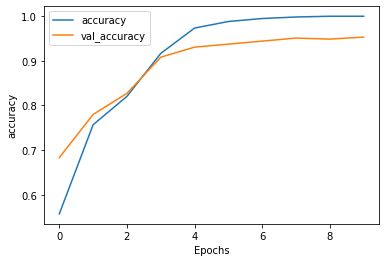

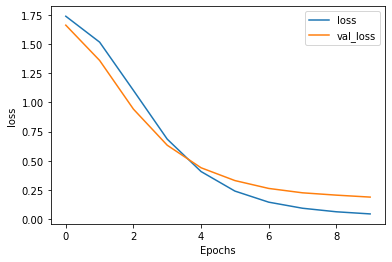

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")